# Intoroduction

Natural Language Inferencing (NLI) task is one of the most important subsets of Natural Language Processing (NLP). NLI is also known as Recognizing Textual Entailment (RTE). NLI is a task of determining whether the given “hypothesis” and “premise” logically follow (entailment) or unfollow (contradiction) or are undetermined (neutral) to each other. In other words, the task of NLI is also defined as determining whether a "hypothesis" is true (entailment), false (contradiction), or undetermined (neutral) given a "premise". Table 1 gives some examples of these three cases.

| Text (Premise) | Hypothesis | Judgement (Label) |
| --- | --- | --- |
| A soccer game with multiple males playing. | Some men are playing a sport. | entailment |
| --- | --- | --- |
| A black race car starts up in front of a crowd of people. | A man is driving down a lonely road. | contradiction |
| --- | --- | --- |
| An older and a younger man smiling. | Two men are smiling and laughing at the cats playing on the floor. | neutral |

# Reading and preparing data

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from nltk.corpus import stopwords
import pickle
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import random
import math
from textblob import TextBlob
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk, string
from collections import Counter
from nltk.stem import WordNetLemmatizer 
import Levenshtein
%matplotlib inline

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Setting seed
global_seed = 42
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
train_df = pd.read_csv('data/snli_1.0/snli_1.0_train.txt', sep='\t')
val_df = pd.read_csv('data/snli_1.0/snli_1.0_dev.txt', sep='\t')
test_df = pd.read_csv('data/snli_1.0/snli_1.0_test.txt', sep='\t')

In [4]:
print(f"train data shape: {train_df.shape}\nvalidation data shape:{val_df.shape}\ntest data shape:{test_df.shape}")

train data shape: (550152, 14)
validation data shape:(10000, 14)
test data shape:(10000, 14)


In [5]:
print(f"all the columns in the dataset:{list(train_df.columns)}")

all the columns in the dataset:['gold_label', 'sentence1_binary_parse', 'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse', 'sentence1', 'sentence2', 'captionID', 'pairID', 'label1', 'label2', 'label3', 'label4', 'label5']


**Here sentence1 represents premise, sentence2 represents hypothesis and gold_label represents our target variable i.e. whether hypothesis entails or contradicts the premise. neutral gold_label suggests no relationship between premise and hypothesis**

In [6]:
train_df.head(5)

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


**we only need sentence1, sentence2 and gold_label columns. Therefore let us drop rest of the columns**

In [7]:
to_keep = ['sentence1', 'sentence2', 'gold_label']
train_df = train_df[to_keep]
val_df = val_df[to_keep]
test_df = test_df[to_keep]

In [8]:
train_df.head(5)

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


### Checking and dealing with null values

In [9]:
train_df[train_df.isna().any(axis=1)]

,sentence1,sentence2,gold_label
91479,Cannot see picture to describe.,NaN,neutral
91480,Cannot see picture to describe.,NaN,entailment
91481,Cannot see picture to describe.,NaN,contradiction
311124,Jumping with purple balls is so much fun!,NaN,contradiction
311125,Jumping with purple balls is so much fun!,NaN,neutral
311126,Jumping with purple balls is so much fun!,NaN,entailment


In [10]:
val_df[val_df.isna().any(axis=1)]

,sentence1,sentence2,gold_label


In [11]:
test_df[test_df.isna().any(axis=1)]

,sentence1,sentence2,gold_label


**6 rows in train data have NaN values. It is better to drop these rows because we can not find appropriate sentences here and inserting some sentences on our own based on target would be inappropriate**

In [12]:
train_df = train_df.drop(train_df.index[train_df[train_df.isna().any(axis=1)].index])

In [13]:
train_df['gold_label'].unique()

array(['neutral', 'contradiction', 'entailment', '-'], dtype=object)

In [14]:
train_df.groupby(by = 'gold_label').count()

,sentence1,sentence2
gold_label,,
-,785,785
contradiction,183185,183185
entailment,183414,183414
neutral,182762,182762


In [15]:
train_df.shape

(550146, 3)

In [16]:
train_df[train_df['gold_label'].values != '-'].shape

(549361, 3)

**we can see that there are some sentence pairs for which the label is '-' i.e. it is undetermined. Out of 550152 such pairs 785 pairs have undetermined label. Since target variable is unknown for these pairs and number of such pairs is too low compared to the number of pairs for which target label is present, we can drop the pairs where label is undetermined** 

In [17]:
train_df = train_df[train_df['gold_label'].values != '-']
val_df = val_df[val_df['gold_label'].values != '-']
test_df = test_df[test_df['gold_label'].values != '-']

In [18]:
train_df['gold_label'].unique()

array(['neutral', 'contradiction', 'entailment'], dtype=object)

In [19]:
train_df.groupby(by = 'gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,183185,183185
entailment,183414,183414
neutral,182762,182762


**Since this is a standard benchmark dataset, there is almost same number of training examples for all target classes. So there is no imbalance in the dataset and hence accuracy can be taken as key performance index**

**Let us look at some random pair of sentences**

In [20]:
for i,row in train_df.sample(15).iterrows():
    print(f"index: {i}\nsentence1: {row['sentence1']}\nsentence2: {row['sentence2']}\nlabel: {row['gold_label']}\n")
    print('*'*100)

index: 71202
sentence1: A woman plays a violin outdoors.
sentence2: The ball room dancer slipped on a banana peel.
label: contradiction

****************************************************************************************************
index: 178279
sentence1: The red panted cyclist is amongst nature.
sentence2: The cyclist is outdoors.
label: entailment

****************************************************************************************************
index: 478971
sentence1: A bicyclist is doing a trick in midair.
sentence2: The bicycle is slowly rolling down the straight.
label: contradiction

****************************************************************************************************
index: 7164
sentence1: Two motorcyclists racing neck and neck around a corner.
sentence2: The two motorcyclists are racing each other.
label: entailment

****************************************************************************************************
index: 237603
sentence1: A middle-ag

**Since it is a human labelled data prepared by researchers at stanform using amazon mechanical turk crowdsourcing service, the data is pretty clean. We only need to remove punctuation and numerical values if present in the data, make all character lower case.**

# Cleaning and preprocessing text

**Along with classification task, once we get good performance on classification task, we will also try to use the trained model to generate universal sentence embeddings. Therefore keeping all the words in your corpora in necessary. For this reason we will not remove stopwords**

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        if type(sentence) != str:
            sent = ' '
        else:
            sent = decontracted(sentence)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\n', ' ')
            sent = sent.replace('\\"', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split())
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [23]:
train_df['sentence1_preprocessed'] = preprocess_text(train_df['sentence1'].values)
val_df['sentence1_preprocessed'] = preprocess_text(val_df['sentence1'].values)
test_df['sentence1_preprocessed'] = preprocess_text(test_df['sentence1'].values)
train_df['sentence2_preprocessed'] = preprocess_text(train_df['sentence2'].values)
val_df['sentence2_preprocessed'] = preprocess_text(val_df['sentence2'].values)
test_df['sentence2_preprocessed'] = preprocess_text(test_df['sentence2'].values)

100%|███████████████████████████████████████████████████████████████████████████| 9824/9824 [00:00<00:00, 84667.25it/s]


In [24]:
for i,row in train_df.sample(5).iterrows():
    print(f"index: {i}\nsentence1: {row['sentence1']}\npreprocessed sentence1: \
    {row['sentence1_preprocessed']}\nsentence2: {row['sentence2']}\npreprocessed sentence2: \
    {row['sentence2_preprocessed']}\nlabel: {row['gold_label']}\n")
    print('*'*100)

index: 172202
sentence1: Dancers in white are performing on a blacked out stage with a pink lighted hue illuminating them.
preprocessed sentence1:     dancers in white are performing on a blacked out stage with a pink lighted hue illuminating them
sentence2: Dancers are dancing.
preprocessed sentence2:     dancers are dancing
label: entailment

****************************************************************************************************
index: 222740
sentence1: A man in a black jacket is riding a horse on a public sidewalk.
preprocessed sentence1:     a man in a black jacket is riding a horse on a public sidewalk
sentence2: A man is in a parade.
preprocessed sentence2:     a man is in a parade
label: neutral

****************************************************************************************************
index: 75709
sentence1: A baseball pitcher wearing a blue, red and white uniform is about to throw a baseball.
preprocessed sentence1:     a baseball pitcher wearing a blue 

In [25]:
for i,row in val_df.sample(5).iterrows():
    print(f"index: {i}\nsentence1: {row['sentence1']}\npreprocessed sentence1: \
    {row['sentence1_preprocessed']}\nsentence2: {row['sentence2']}\npreprocessed sentence2: \
    {row['sentence2_preprocessed']}\nlabel: {row['gold_label']}\n")
    print('*'*100)

index: 231
sentence1: A middle-aged man is sitting indian style outside holding a folded paper in his hands.
preprocessed sentence1:     a middle aged man is sitting indian style outside holding a folded paper in his hands
sentence2: A middle aged man is outdoors.
preprocessed sentence2:     a middle aged man is outdoors
label: entailment

****************************************************************************************************
index: 9542
sentence1: little boy running in the street.
preprocessed sentence1:     little boy running in the street
sentence2: A boy is running to school in the street.
preprocessed sentence2:     a boy is running to school in the street
label: neutral

****************************************************************************************************
index: 4964
sentence1: A person is walking down a cobblestone street.
preprocessed sentence1:     a person is walking down a cobblestone street
sentence2: The person walking has shoes on.
preprocessed

In [26]:
for i,row in test_df.sample(5).iterrows():
    print(f"index: {i}\nsentence1: {row['sentence1']}\npreprocessed sentence1: \
    {row['sentence1_preprocessed']}\nsentence2: {row['sentence2']}\npreprocessed sentence2: \
    {row['sentence2_preprocessed']}\nlabel: {row['gold_label']}\n")
    print('*'*100)

index: 3109
sentence1: A man sits at a table in a room.
preprocessed sentence1:     a man sits at a table in a room
sentence2: A woman sits.
preprocessed sentence2:     a woman sits
label: contradiction

****************************************************************************************************
index: 82
sentence1: Three people sit on a bench at a station, the man looks oddly at the two women, the redheaded women looks up and forward in an awkward position, and the yellow blond girl twiddles with her hair.
preprocessed sentence1:     three people sit on a bench at a station the man looks oddly at the two women the redheaded women looks up and forward in an awkward position and the yellow blond girl twiddles with her hair
sentence2: People run together.
preprocessed sentence2:     people run together
label: contradiction

****************************************************************************************************
index: 9089
sentence1: Two boys in a canoe in front of a 

In [27]:
train_df['gold_label'].value_counts()[0]

183414

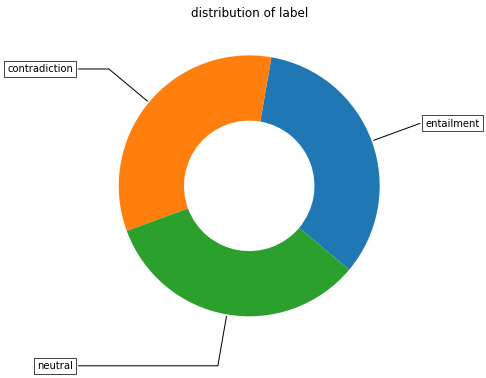

In [28]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = train_df['gold_label'].value_counts()
# print("Number of entailments ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
# print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["entailment", "contradiction", "neutral"]

data = [y_value_counts[0], y_value_counts[1], y_value_counts[2]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("distribution of label")

plt.show()

**As we saw earlier, the dataset is balanced from the point of view of target variable**

In [45]:
def get_num_words(sentence):
    return(len(sentence.split(' ')))    

In [46]:
train_df['sentence1_num_words'] = train_df['sentence1_preprocessed'].apply(get_num_words)
val_df['sentence1_num_words'] = val_df['sentence1_preprocessed'].apply(get_num_words)
test_df['sentence1_num_words'] = test_df['sentence1_preprocessed'].apply(get_num_words)
train_df['sentence2_num_words'] = train_df['sentence2_preprocessed'].apply(get_num_words)
val_df['sentence2_num_words'] = val_df['sentence2_preprocessed'].apply(get_num_words)
test_df['sentence2_num_words'] = test_df['sentence2_preprocessed'].apply(get_num_words)

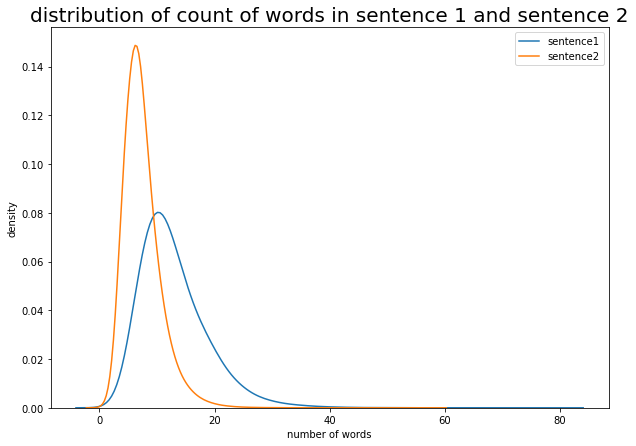

In [47]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
sns.kdeplot(x = train_df['sentence1_num_words'], ax = ax, label = "sentence1", bw_adjust = 5)
sns.kdeplot(x = train_df['sentence2_num_words'], ax = ax, label = "sentence2", bw_adjust = 5)
ax.set_xlabel('number of words')
ax.set_ylabel('density')
ax.set_title('distribution of count of words in sentence 1 and sentence 2', fontdict = {'fontsize': 20})
plt.legend()
plt.show()

**In general the number of words in premise(sentence1) is slighlty greater than number of words in hypothesis(sentence2)**

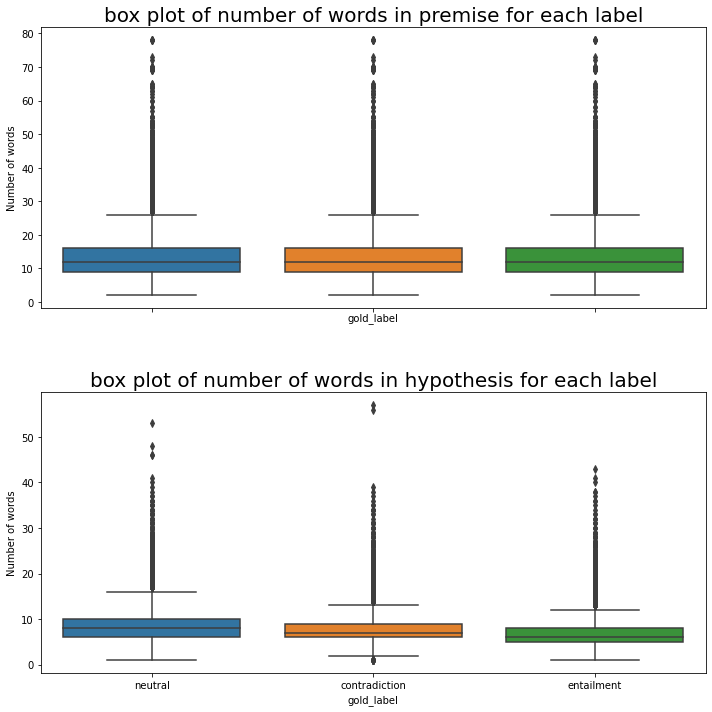

In [32]:
fig,ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
sns.boxplot(x = train_df['gold_label'], y = train_df['sentence1_num_words'], ax = ax[0])
sns.boxplot(x = train_df['gold_label'], y = train_df['sentence2_num_words'], ax = ax[1])
ax[0].set_title('box plot of number of words in premise for each label', fontdict = {'fontsize': 20})
ax[0].set_ylabel('Number of words')
ax[1].set_title('box plot of number of words in hypothesis for each label', fontdict = {'fontsize': 20})
ax[1].set_ylabel('Number of words')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

**In general there is no patern between number of words and label in case of premise. But there is a visible pattern in case of hypothesis. The number of words in hypothesis are highest for neutral, it decreases for contradiction and it is lowest for entailment**

## Difference in num of words in sentence1 and sentence2

In [48]:
train_df['diff_num_words'] = (train_df['sentence1_num_words'] - train_df['sentence2_num_words']).abs()

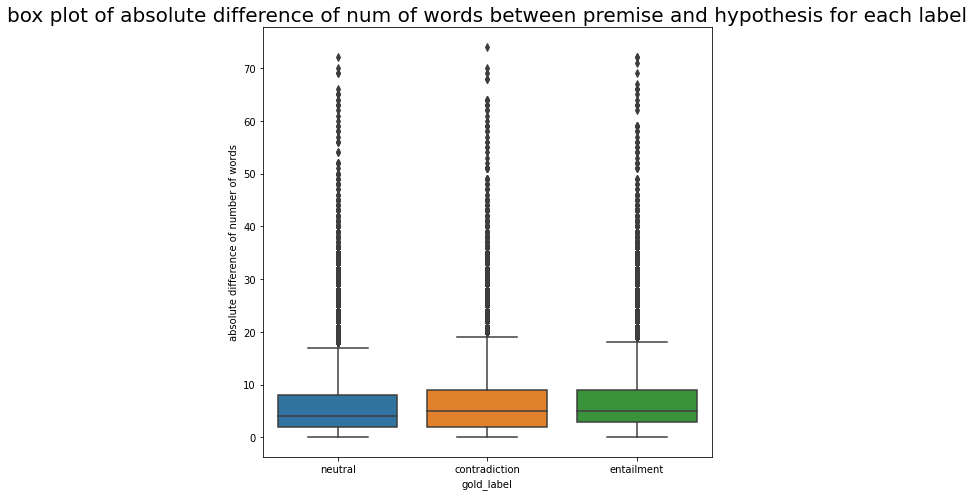

In [49]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.boxplot(x = train_df['gold_label'], y = train_df['diff_num_words'], ax = ax)
ax.set_title('box plot of absolute difference of num of words between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('absolute difference of number of words')
plt.tight_layout()
plt.show()

**Although there is not much difference in general difference in number of words between pairs for neutral, contractiction and entailment sentences, it seems that the ascending order of difference in number of words between two sentences is neutral-->contradiction-->entailment**

In [50]:
val_df['diff_num_words'] = (val_df['sentence1_num_words'] - val_df['sentence2_num_words']).abs()
test_df['diff_num_words'] = (test_df['sentence1_num_words'] - test_df['sentence2_num_words']).abs()

### Plotting Wordcloud for premise and hypothesis to see dominant words in these sentences 

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df['sentence1_preprocessed']
X = vectorizer.fit_transform(data)

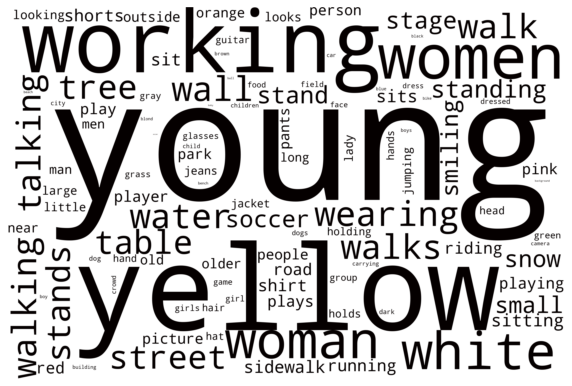

In [34]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**In premise words like yellow, young, women, woman, walking, talking, street, working, wearing, smiling etc. are dominant**

In [35]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df['sentence2_preprocessed']
X = vectorizer.fit_transform(data)

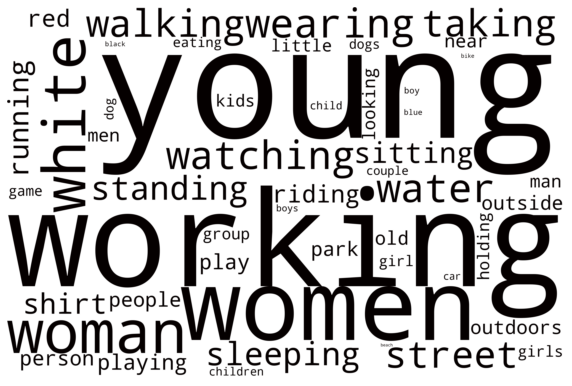

In [36]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Hypothesis also contains words similar to premise**

### Wordcloud for premise for each label

**1. premise--->entailment**

In [37]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df[train_df['gold_label'] == 'entailment']['sentence1_preprocessed']
X = vectorizer.fit_transform(data)

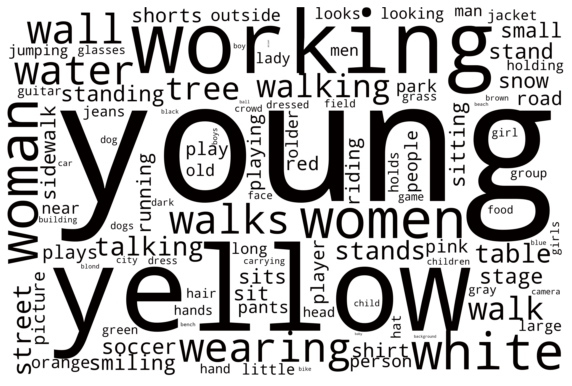

In [38]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**2. premise--->contradiction**

In [39]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df[train_df['gold_label'] == 'contradiction']['sentence1_preprocessed']
X = vectorizer.fit_transform(data)

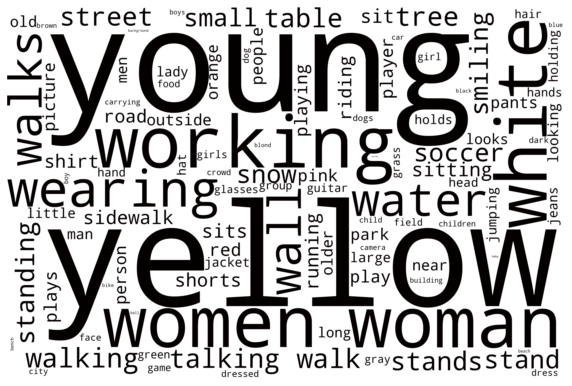

In [40]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**3. premise--->neutral**

In [41]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df[train_df['gold_label'] == 'neutral']['sentence1_preprocessed']
X = vectorizer.fit_transform(data)

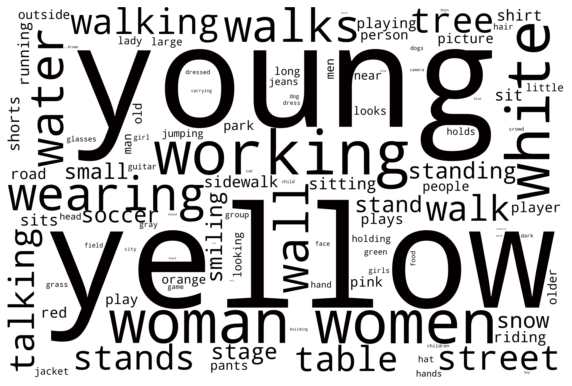

In [42]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordcloud for hypothesis for each label

**1. hypothesis--->entailment**

In [43]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df[train_df['gold_label'] == 'entailment']['sentence2_preprocessed']
X = vectorizer.fit_transform(data)

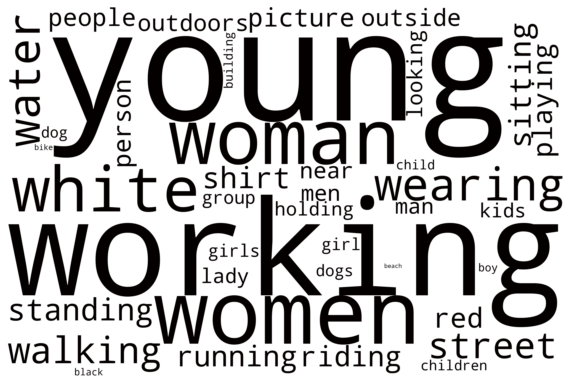

In [44]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**2. hypothesis--->contradiction**

In [45]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df[train_df['gold_label'] == 'contradiction']['sentence2_preprocessed']
X = vectorizer.fit_transform(data)

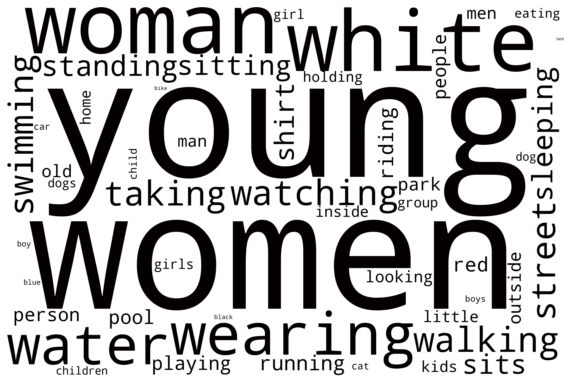

In [46]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**3. hypothesis--->neutral**

In [47]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .8, min_df = .01)
data = train_df[train_df['gold_label'] == 'neutral']['sentence2_preprocessed']
X = vectorizer.fit_transform(data)

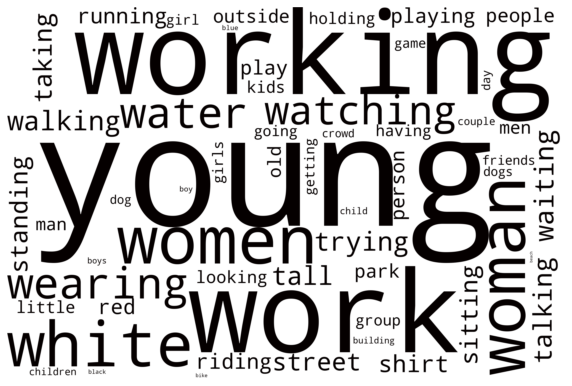

In [48]:
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(vectorizer.vocabulary_)
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### It seems that dominant words in each label for each sentence do not give us much predictive power. We need to engineer more features

## Bleu score between two sentences

In [49]:
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
def get_bleu_score(sentence1, sentence2):
    import nltk.translate.bleu_score as bleu
    sentence1 = sentence1.split(' ')
    sentence2 = sentence2.split(' ')
    bleu_score = bleu.sentence_bleu([sentence1,], sentence2)
    return bleu_score

In [50]:
train_bleu_lst = list()
for i,row in train_df.iterrows():
    sentence1 = row['sentence1_preprocessed']
    sentence2 = row['sentence2_preprocessed']
    bleu = get_bleu_score(sentence1, sentence2)
    train_bleu_lst.append(bleu)

In [51]:
val_bleu_lst = list()
for i,row in val_df.iterrows():
    sentence1 = row['sentence1_preprocessed']
    sentence2 = row['sentence2_preprocessed']
    bleu = get_bleu_score(sentence1, sentence2)
    val_bleu_lst.append(bleu)

In [52]:
test_bleu_lst = list()
for i,row in test_df.iterrows():
    sentence1 = row['sentence1_preprocessed']
    sentence2 = row['sentence2_preprocessed']
    bleu = get_bleu_score(sentence1, sentence2)
    test_bleu_lst.append(bleu)

In [53]:
len(val_bleu_lst)

9842

In [54]:
len(test_bleu_lst)

9824

In [55]:
train_df['bleu_score'] = train_bleu_lst
val_df['bleu_score'] = val_bleu_lst
test_df['bleu_score'] = test_bleu_lst

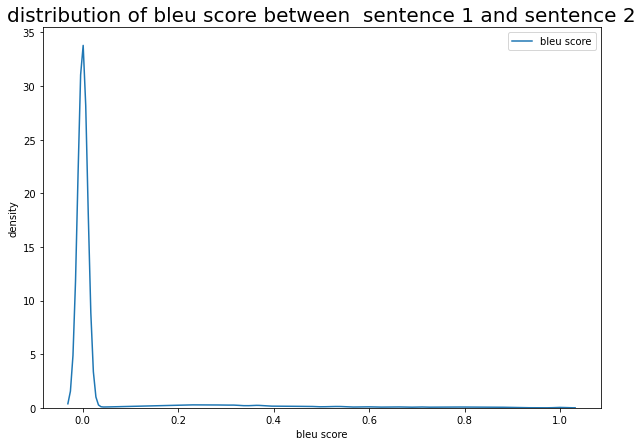

In [56]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
sns.kdeplot(x = train_df['bleu_score'], ax = ax, label = "bleu score")
ax.set_xlabel('bleu score')
ax.set_ylabel('density')
ax.set_title('distribution of bleu score between  sentence 1 and sentence 2', fontdict = {'fontsize': 20})
plt.legend()
plt.show()

**Most of the bleu scores are close to 0 few are greater than 0 and even fewer reach 1**

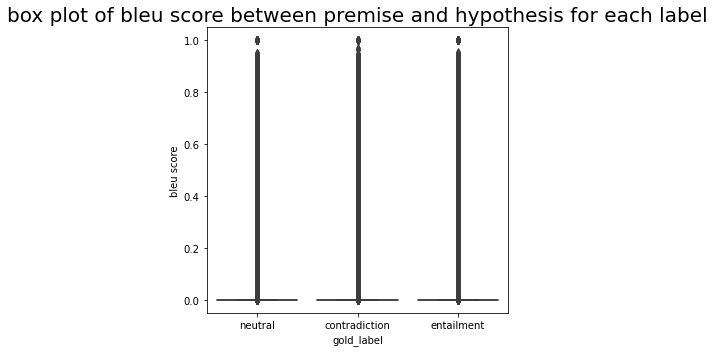

In [57]:
fig,ax = plt.subplots(1,1, figsize=(5,5), sharex=True)
sns.boxplot(x = train_df['gold_label'], y = train_df['bleu_score'], ax = ax)
ax.set_title('box plot of bleu score between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('bleu score')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

### **Let us plot on log scale**

In [52]:
def get_log(x):
    if x != 0:
        return math.log(x)
    else:
        return 0

In [59]:
train_df['log_bleu_score'] = train_df['bleu_score'].apply(get_log)

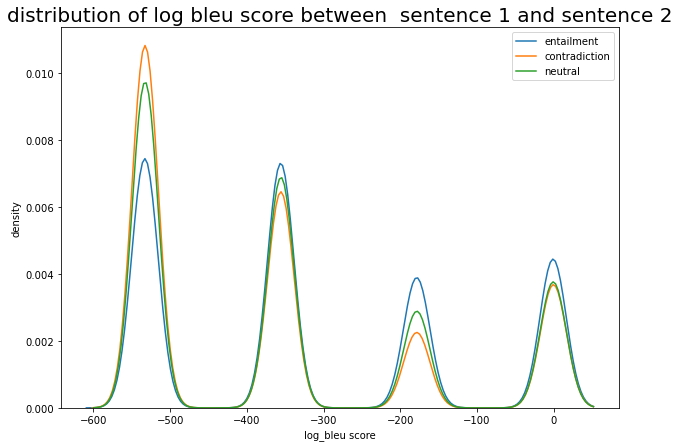

In [60]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
sns.kdeplot(x = train_df[train_df['gold_label'] == 'entailment']['log_bleu_score'], ax = ax, label = 'entailment')
sns.kdeplot(x = train_df[train_df['gold_label'] == 'contradiction']['log_bleu_score'], ax = ax, label = 'contradiction')
sns.kdeplot(x = train_df[train_df['gold_label'] == 'neutral']['log_bleu_score'], ax = ax, label = 'neutral')
ax.set_xlabel('log_bleu score')
ax.set_ylabel('density')
ax.set_title('distribution of log bleu score between  sentence 1 and sentence 2', fontdict = {'fontsize': 20})
plt.legend()
plt.show()

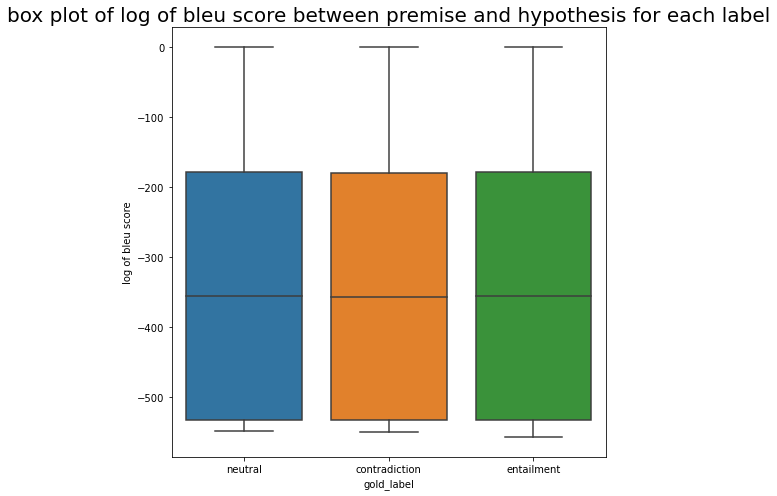

In [61]:
fig,ax = plt.subplots(1,1, figsize=(7,7), sharex=True)
sns.boxplot(x = train_df['gold_label'], y = train_df['log_bleu_score'], ax = ax)
ax.set_title('box plot of log of bleu score between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('log of bleu score')
plt.tight_layout()
plt.show()

**it seems that log of bleu score has some discriminating power in some ranges**

In [53]:
val_df['log_bleu_score'] = val_df['bleu_score'].apply(get_log)

In [54]:
test_df['log_bleu_score'] = test_df['bleu_score'].apply(get_log)

## Sentiment score

In [62]:
s = 'thi food is too bad'
s = TextBlob(s)
print(s.sentiment.polarity)
print(s.sentiment.subjectivity)

-0.6999999999999998
0.6666666666666666


In [63]:
def get_sentiment(x, option):
    
    """
    returns polarity score if option = 'polarity'
    returns subjectivity score is option = 'subjectivity'
    x = input sentence
    """
    
    x = TextBlob(x)
    if option == 'polarity':
        return x.sentiment.polarity
    if option == 'subjectivity':
        return x.sentiment.subjectivity
    

### calculating polarity score sentence1

In [64]:
train_df['sentence1_polarity'] = train_df['sentence1'].apply(lambda x: get_sentiment(x, 'polarity'))
val_df['sentence1_polarity'] = val_df['sentence1'].apply(lambda x: get_sentiment(x, 'polarity'))
test_df['sentence1_polarity'] = test_df['sentence1'].apply(lambda x: get_sentiment(x, 'polarity'))

### calculating polarity score sentence2

In [65]:
train_df['sentence2_polarity'] = train_df['sentence2'].apply(lambda x: get_sentiment(x, 'polarity'))
val_df['sentence2_polarity'] = val_df['sentence2'].apply(lambda x: get_sentiment(x, 'polarity'))
test_df['sentence2_polarity'] = test_df['sentence2'].apply(lambda x: get_sentiment(x, 'polarity'))

### calculating subjectivity score sentence1

In [66]:
train_df['sentence1_subjectivity'] = train_df['sentence1'].apply(lambda x: get_sentiment(x, 'subjectivity'))
val_df['sentence1_subjectivity'] = val_df['sentence1'].apply(lambda x: get_sentiment(x, 'subjectivity'))
test_df['sentence1_subjectivity'] = test_df['sentence1'].apply(lambda x: get_sentiment(x, 'subjectivity'))

### calculating subjectivity score sentence2

In [67]:
train_df['sentence2_subjectivity'] = train_df['sentence2'].apply(lambda x: get_sentiment(x, 'subjectivity'))
val_df['sentence2_subjectivity'] = val_df['sentence2'].apply(lambda x: get_sentiment(x, 'subjectivity'))
test_df['sentence2_subjectivity'] = test_df['sentence2'].apply(lambda x: get_sentiment(x, 'subjectivity'))

### Let us conduct some analysis in cases where polarity scores for two sentences are equal and not equal

In [68]:
train_df.shape

(549361, 13)

In [69]:
train_df[train_df['sentence1_polarity'] == train_df['sentence2_polarity']].shape

(250594, 13)

**We can see that out of 549361 training examples, 250594 examples have same exactly polarity score for sentence1 and sentence2. Let us see how that relates to our target variable**

In [70]:
train_df[train_df['sentence1_polarity'] == train_df['sentence2_polarity']].groupby(by = 'gold_label').count()

,sentence1,sentence2,sentence1_preprocessed,sentence2_preprocessed,sentence1_num_words,sentence2_num_words,bleu_score,log_bleu_score,sentence1_polarity,sentence2_polarity,sentence1_subjectivity,sentence2_subjectivity
gold_label,,,,,,,,,,,,
contradiction,82970,82970,82970,82970,82970,82970,82970,82970,82970,82970,82970,82970
entailment,91746,91746,91746,91746,91746,91746,91746,91746,91746,91746,91746,91746
neutral,75878,75878,75878,75878,75878,75878,75878,75878,75878,75878,75878,75878


In [71]:
82970+91746+75878

250594

In [72]:
train_df[train_df['sentence1_polarity'] != train_df['sentence2_polarity']].groupby(by = 'gold_label').count()

,sentence1,sentence2,sentence1_preprocessed,sentence2_preprocessed,sentence1_num_words,sentence2_num_words,bleu_score,log_bleu_score,sentence1_polarity,sentence2_polarity,sentence1_subjectivity,sentence2_subjectivity
gold_label,,,,,,,,,,,,
contradiction,100215,100215,100215,100215,100215,100215,100215,100215,100215,100215,100215,100215
entailment,91668,91668,91668,91668,91668,91668,91668,91668,91668,91668,91668,91668
neutral,106884,106884,106884,106884,106884,106884,106884,106884,106884,106884,106884,106884


**there are almost equal number of training examples for entailment when polarity score is equal and not equal for two sentences. For contradiction number of training examples are more when polarity score of two sentences are not equal. Similar case can be seen for neutral. So equality of polarity score may have some predictive power.**

### Let us conduct some analysis in cases where subjectivity scores for two sentences are equal and not equal

In [73]:
train_df.shape

(549361, 13)

In [74]:
train_df[train_df['sentence1_subjectivity'] == train_df['sentence2_subjectivity']].shape

(208181, 13)

**We can see that out of 549361 training examples, 208181 examples have same exactly subjectivity score for sentence1 and sentence2. Let us see how that relates to our target variable**

In [75]:
train_df[train_df['sentence1_subjectivity'] == train_df['sentence2_subjectivity']].groupby(by = 'gold_label').count()

,sentence1,sentence2,sentence1_preprocessed,sentence2_preprocessed,sentence1_num_words,sentence2_num_words,bleu_score,log_bleu_score,sentence1_polarity,sentence2_polarity,sentence1_subjectivity,sentence2_subjectivity
gold_label,,,,,,,,,,,,
contradiction,69715,69715,69715,69715,69715,69715,69715,69715,69715,69715,69715,69715
entailment,75200,75200,75200,75200,75200,75200,75200,75200,75200,75200,75200,75200
neutral,63266,63266,63266,63266,63266,63266,63266,63266,63266,63266,63266,63266


In [76]:
train_df[train_df['sentence1_subjectivity'] != train_df['sentence2_subjectivity']].groupby(by = 'gold_label').count()

,sentence1,sentence2,sentence1_preprocessed,sentence2_preprocessed,sentence1_num_words,sentence2_num_words,bleu_score,log_bleu_score,sentence1_polarity,sentence2_polarity,sentence1_subjectivity,sentence2_subjectivity
gold_label,,,,,,,,,,,,
contradiction,113470,113470,113470,113470,113470,113470,113470,113470,113470,113470,113470,113470
entailment,108214,108214,108214,108214,108214,108214,108214,108214,108214,108214,108214,108214
neutral,119496,119496,119496,119496,119496,119496,119496,119496,119496,119496,119496,119496


**There is a lot of difference between number of training examples when subjectivity is equal and when it is not equal. Even though this does not contribute to discriminative power between entailment, contradiction and neutral labels it can still be of some help in predictions. We will have to see this when proceed for actual modelling**

In [77]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')

In [4]:
train_df = pd.read_csv('train_df.csv', index_col = 0)
val_df = pd.read_csv('val_df.csv', index_col = 0)
test_df = pd.read_csv('test_df.csv', index_col = 0)

## Sum of polarity scores of sentence1 and sentence2 

In [5]:
train_df['sum_polarity'] = train_df['sentence1_polarity'] + train_df['sentence2_polarity']

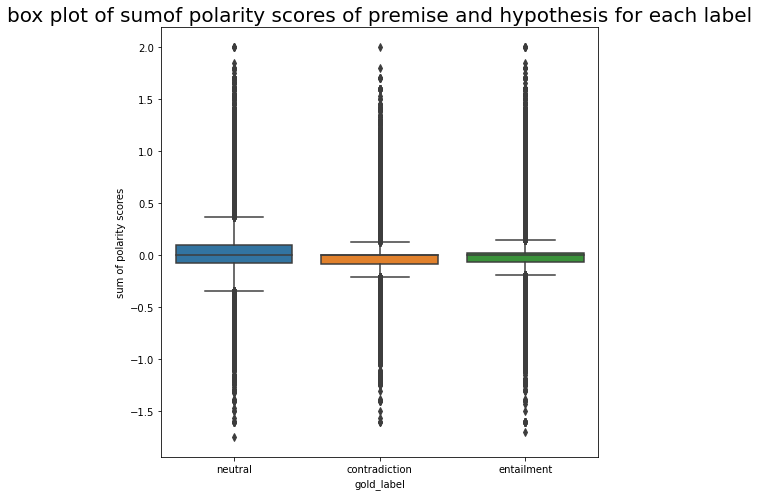

In [6]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.boxplot(x = train_df['gold_label'], y = train_df['sum_polarity'], ax = ax)
ax.set_title('box plot of sumof polarity scores of premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('sum of polarity scores')
plt.tight_layout()
plt.show()

**sum of polarity scores seems to be somewhat helpful in classification. polarity scores lie between -1(negative) and 1(positive). So if both sentences have similar polarity then adding those will further make these polarity scores extreme. For example if both sentences have polarity score of -1 then adding both will give -2. But if the two sentences have different polarity then adding these will give(most probably) a score near to 0. This behaviour is what is visible in the box plots. Most of the added polarity scores lie near to 0. Then there are no added scores around the boxes and added polarity scores can be seen further away from the boxes(extreme values). Also the boxes are not perfectly aligned for all the three labels. So this feature might be helpful in classification**

In [7]:
val_df['sum_polarity'] = val_df['sentence1_polarity'] + val_df['sentence2_polarity']
test_df['sum_polarity'] = test_df['sentence1_polarity'] + test_df['sentence2_polarity']

## absolute difference of subjectivity scores of two sentences

In [8]:
train_df['diff_subjectivity'] = (train_df['sentence1_subjectivity'] - train_df['sentence2_subjectivity']).abs()

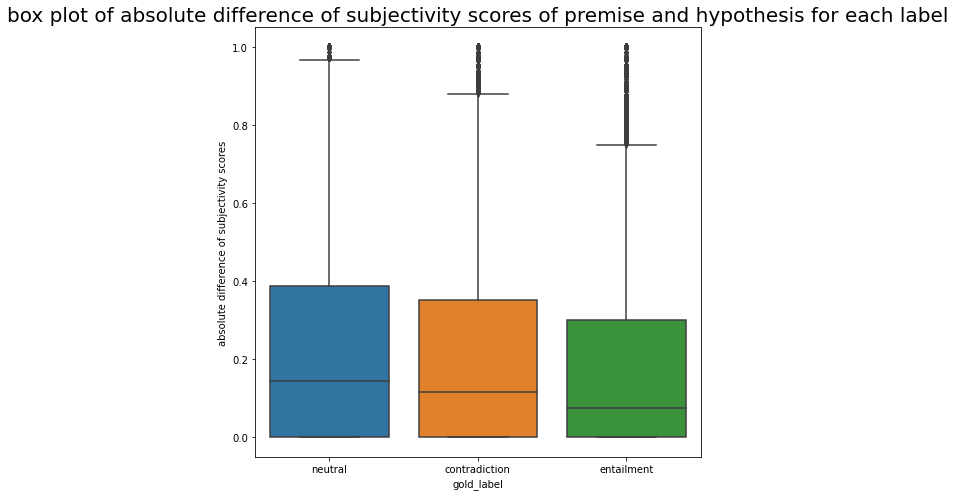

In [9]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.boxplot(x = train_df['gold_label'], y = train_df['diff_subjectivity'], ax = ax)
ax.set_title('box plot of absolute difference of subjectivity scores of premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('absolute difference of subjectivity scores')
plt.tight_layout()
plt.show()

**absolute difference between subjectivity scores for neutral seem to be higher than contradiction and entailment. Further the same score for contradiction is higher than entailment.**

In [10]:
val_df['diff_subjectivity'] = (val_df['sentence1_subjectivity'] - val_df['sentence2_subjectivity']).abs()
test_df['diff_subjectivity'] = (test_df['sentence1_subjectivity'] - test_df['sentence2_subjectivity']).abs()

## word count based cosine similarity

In [11]:
#function to calculate cosine similarity between two sentences
WORD = re.compile(r"\w+")
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


In [12]:
text1 = train_df['sentence1'][0]
text2 = train_df['sentence2'][0]

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

cosine = get_cosine(vector1, vector2)

### Train cosine similarity

In [13]:
train_cosine_sim = list()
for i,row in train_df.iterrows():
    text1 = row['sentence1']
    text2 = row['sentence2']
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine = get_cosine(vector1, vector2)
    train_cosine_sim.append(cosine)

    

In [14]:
train_df['cosine_similarity'] = train_cosine_sim

In [15]:
print(f"minimum cosine similarity: {train_df['cosine_similarity'].min()}\nmaximum cosine similarity: \
{train_df['cosine_similarity'].max()}")

minimum cosine similarity: 0.0
maximum cosine similarity: 1.0000000000000002


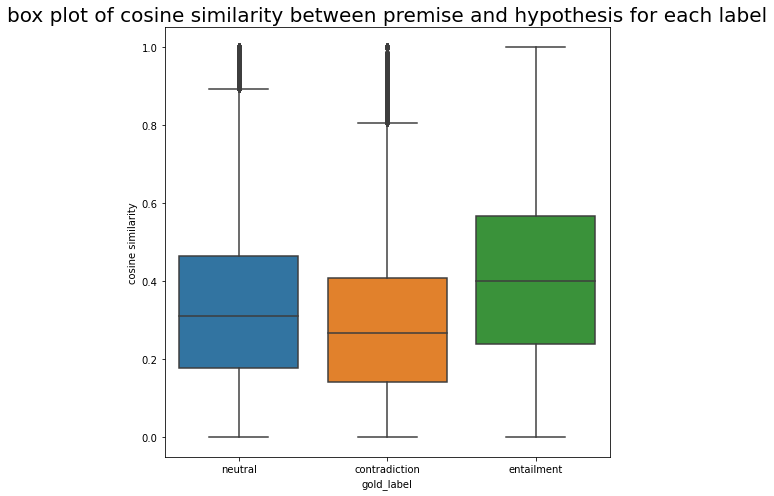

In [16]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.boxplot(x = train_df['gold_label'], y = train_df['cosine_similarity'], ax = ax)
ax.set_title('box plot of cosine similarity between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('cosine similarity')
plt.tight_layout()
plt.show()

**cosine similarity does seem to have some predictive power. Particulary cosine similarities for contradiction and entailment do not overlap much**

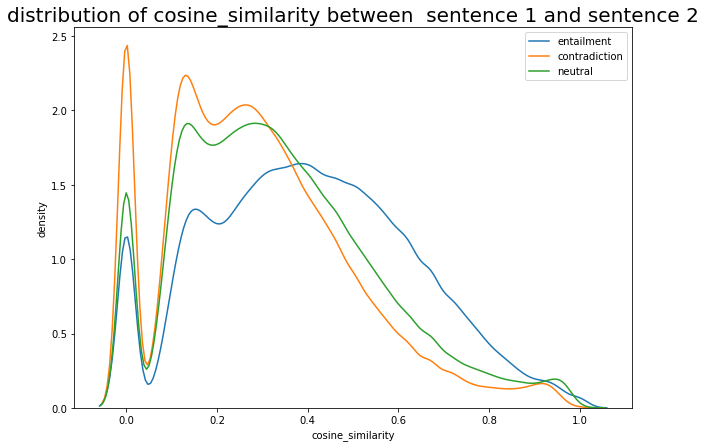

In [103]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
sns.kdeplot(x = train_df[train_df['gold_label'] == 'entailment']['cosine_similarity'], ax = ax, label = 'entailment')
sns.kdeplot(x = train_df[train_df['gold_label'] == 'contradiction']['cosine_similarity'], ax = ax, label = 'contradiction')
sns.kdeplot(x = train_df[train_df['gold_label'] == 'neutral']['cosine_similarity'], ax = ax, label = 'neutral')
ax.set_xlabel('cosine_similarity')
ax.set_ylabel('density')
ax.set_title('distribution of cosine_similarity between  sentence 1 and sentence 2', fontdict = {'fontsize': 20})
plt.legend()
plt.show()

**mostly cosine similarities for all the labels follow similar distribution. But towards the higher end of the distribution(after cosine similarity value of 0.4) more desnity is seen for entailment pairs. This should be expected because if hypothesis entails premise then they should be similar**

### validation cosine similarity

In [17]:
val_cosine_sim = list()
for i,row in val_df.iterrows():
    text1 = row['sentence1']
    text2 = row['sentence2']
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine = get_cosine(vector1, vector2)
    val_cosine_sim.append(cosine)

    

In [19]:
val_df['cosine_similarity'] = val_cosine_sim

### Test cosine similarity

In [20]:
test_cosine_sim = list()
for i,row in test_df.iterrows():
    text1 = row['sentence1']
    text2 = row['sentence2']
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine = get_cosine(vector1, vector2)
    test_cosine_sim.append(cosine)

    

In [21]:
test_df['cosine_similarity'] = test_cosine_sim

## Cosine similarity between tfidf vectors

In [31]:
#https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize)

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]


### tfidf cosine similarity for training data

In [32]:
tfidf_cos_sim = list()
for i,row in train_df.iterrows():
    cos_sim = cosine_sim(row['sentence1'], row['sentence2'])
    tfidf_cos_sim.append(cos_sim)

In [33]:
train_df['tfidf_cosine_sim'] = tfidf_cos_sim

### tfidf cosine similarity for validation data

In [34]:
tfidf_cos_sim = list()
for i,row in val_df.iterrows():
    cos_sim = cosine_sim(row['sentence1'], row['sentence2'])
    tfidf_cos_sim.append(cos_sim)

In [35]:
val_df['tfidf_cosine_sim'] = tfidf_cos_sim

### tfidf cosine similarity for test data

In [36]:
tfidf_cos_sim = list()
for i,row in test_df.iterrows():
    cos_sim = cosine_sim(row['sentence1'], row['sentence2'])
    tfidf_cos_sim.append(cos_sim)

In [37]:
test_df['tfidf_cosine_sim'] = tfidf_cos_sim

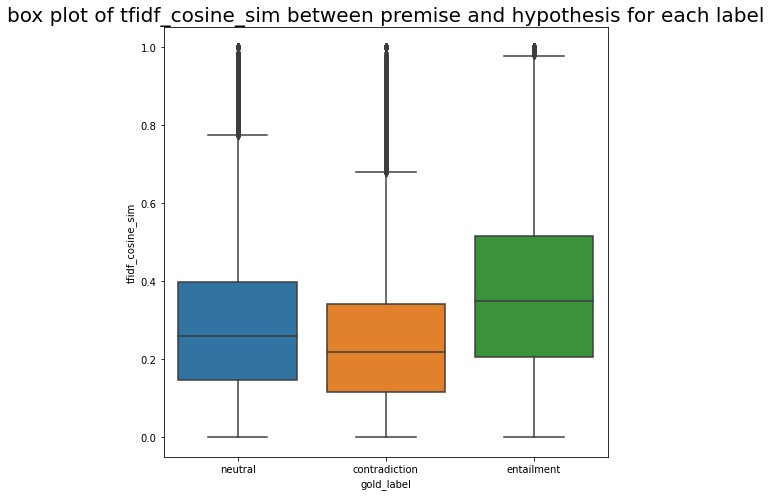

In [38]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.boxplot(x = train_df['gold_label'], y = train_df['tfidf_cosine_sim'], ax = ax)
ax.set_title('box plot of tfidf_cosine_sim between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('tfidf_cosine_sim')
plt.tight_layout()
plt.show()

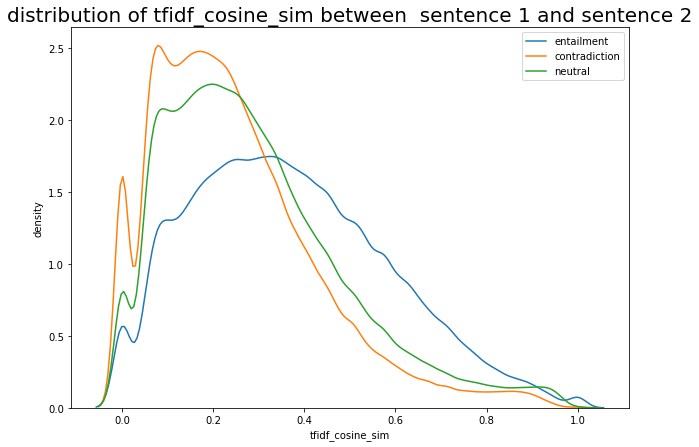

In [39]:
fig,ax = plt.subplots(1,1, figsize=(10,7))
sns.kdeplot(x = train_df[train_df['gold_label'] == 'entailment']['tfidf_cosine_sim'], ax = ax, label = 'entailment')
sns.kdeplot(x = train_df[train_df['gold_label'] == 'contradiction']['tfidf_cosine_sim'], ax = ax, label = 'contradiction')
sns.kdeplot(x = train_df[train_df['gold_label'] == 'neutral']['tfidf_cosine_sim'], ax = ax, label = 'neutral')
ax.set_xlabel('tfidf_cosine_sim')
ax.set_ylabel('density')
ax.set_title('distribution of tfidf_cosine_sim between  sentence 1 and sentence 2', fontdict = {'fontsize': 20})
plt.legend()
plt.show()

**cosine similarity calculated on tfidf vectors of sentence1 and sentence2 seem to be good when it comes to seperating target varibale classes. This similarity is lowest for contradictory pair and highest for etailing pairs which is expected behaviour. There is a kind of a crossing region between 0.2 and 0.3 where kde for entailment and kde for contradiction intesect each other showing that for lower values of cosine similarity density of contradictory pairs is greater while for higher values of cosine similarity density of entailment pairs is greater**

In [61]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')

In [174]:
train_df = pd.read_csv('train_df.csv', index_col = 0)
val_df = pd.read_csv('val_df.csv', index_col = 0)
test_df = pd.read_csv('test_df.csv', index_col = 0)

## Count of pos tags for sentence1 and sentence2

In [63]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [178]:
def pos_counter(text, s):
    """
    This function returns the count of occurence of different parts of speech in a sentence
    argument s specifies which sentence are we precossing. sentence1 or sentence2
    """
    pos_cols = ['CC', 'IN', 'JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tags = nltk.pos_tag(lemmatized_tokens)
    counts = Counter( tag for word,  tag in tags)
    if s == 'sentence1':
        count_dict = {'s1_'+k:v for k,v in dict(counts).items() if k in pos_cols}
    if s == 'sentence2':
        count_dict = {'s2_'+k:v for k,v in dict(counts).items() if k in pos_cols}
        
    return count_dict
    

In [181]:
s = "dark matter written by blake crouch."
s_c = pos_counter(s, 'sentence2')

In [182]:
s_c

{'s2_JJ': 1, 's2_NN': 3, 's2_VBN': 1, 's2_IN': 1}

### Meaning of each pos tag from nltk:
CC: conjunction, coordinating<br>
CD: numeral, cardinal<br>
DT: determiner<br>
EX: existential there<br>
IN: preposition or conjunction, subordinating<br>
JJ: adjective or numeral, ordinal<br>
JJR: adjective, comparative<br>
JJS: adjective, superlative<br>
LS: list item marker<br>
MD: modal auxiliary<br>
NN: noun, common, singular or mass<br>
NNP: noun, proper, singular<br>
NNS: noun, common, plural<br>
PDT: pre-determiner<br>
PRP: pronoun, personal<br>
PRP$: pronoun, possessive<br>
RB: adverb<br>
RBR: adverb, comparative<br>
RBS: adverb, superlative<br>
RP: particle<br>
UH: interjection<br>
VB: verb, base form<br>
VBD: verb, past tense<br>
VBG: verb, present participle or gerund<br>
VBN: verb, past participle<br>
VBP: verb, present tense, not 3rd person singular<br>
VBZ: verb, present tense, 3rd person singular<br>
WDT: WH-determiner<br>
WP: WH-pronoun<br>
WRB: Wh-adverb<br>

In [80]:
# let us get all pos tags in sentence1 
unique_tags = set()
for i,row in train_df.iterrows():
    tag_dict = pos_counter(row['sentence1'])
    for k,v in tag_dict.items():
        unique_tags.add(k)
    

In [84]:
# let us get all pos tags in sentence2
unique_tags2 = set()
for i,row in train_df.iterrows():
    tag_dict = pos_counter(row['sentence2'])
    for k,v in tag_dict.items():
        unique_tags2.add(k)
    

In [86]:
# combined unique pos tags in both sentences
total_tags = unique_tags.union(unique_tags2)

In [87]:
len(total_tags)

44

### **Process applied to get count of pos tags for both the sentences**<br>
1. Create empty columns in dataframes for count of pos in two sentences.<br>
2. Initialize all values first to 0. prefix 's1' for each tag represents it belongs to count of sentence 1. and prefix 's2' represents it belongs to count of for sentence2
2. consider these pos tags only: CC, IN, JJ, JJR, JJS, NN, NNP, NNS, PRP, PRP$, RB, RBR, RBS, UH, VB, VBD, VBG, VBN, VBP, VBZ<br>
4. now iterate through each row, for each row get dictionalry of count of pos tags for sentence1 and sentence2<br>
5. update count of each pos tag for both the sentences<br>

### Generating pos tags count for train data

In [218]:
# adding empty columns to store count of each pos tag mentioned above
train_df = train_df.reindex(columns=[*train_df.columns.tolist(), 's1_CC', 's1_IN', 's1_JJ', 's1_JJR', 's1_JJS', 
                                     's1_NN', 's1_NNP', 's1_NNS', 's1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS',
                                     's1_UH', 's1_VB', 's1_VBD', 's1_VBG', 's1_VBN', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
                                     's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP', 's2_PRP$', 's2_RB', 
                                     's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD', 's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ'], fill_value=0)

In [210]:
pos_cols = ['CC', 'IN', 'JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

In [219]:
#iterating through each row and storing count of each pos tag for both the sentences
for i,row in train_df.iterrows():
    s1_pos = pos_counter(row['sentence1'], 'sentence1')
    s2_pos = pos_counter(row['sentence2'], 'sentence2')
    for k,v in s1_pos.items():
        train_df.at[i, k] = v
    for k,v in s2_pos.items():
        train_df.at[i, k] = v
        

### Generating pos tags count for validation data

In [228]:
# adding empty columns to store count of each pos tag mentioned above
val_df = val_df.reindex(columns=[*val_df.columns.tolist(), 's1_CC', 's1_IN', 's1_JJ', 's1_JJR', 's1_JJS', 
                                     's1_NN', 's1_NNP', 's1_NNS', 's1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS',
                                     's1_UH', 's1_VB', 's1_VBD', 's1_VBG', 's1_VBN', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
                                     's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP', 's2_PRP$', 's2_RB', 
                                     's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD', 's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ'], fill_value=0)

In [229]:
#iterating through each row and storing count of each pos tag for both the sentences
for i,row in val_df.iterrows():
    s1_pos = pos_counter(row['sentence1'], 'sentence1')
    s2_pos = pos_counter(row['sentence2'], 'sentence2')
    for k,v in s1_pos.items():
        val_df.at[i, k] = v
    for k,v in s2_pos.items():
        val_df.at[i, k] = v
        

### Generating pos tags count for test data

In [230]:
# adding empty columns to store count of each pos tag mentioned above
test_df = test_df.reindex(columns=[*test_df.columns.tolist(), 's1_CC', 's1_IN', 's1_JJ', 's1_JJR', 's1_JJS', 
                                     's1_NN', 's1_NNP', 's1_NNS', 's1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS',
                                     's1_UH', 's1_VB', 's1_VBD', 's1_VBG', 's1_VBN', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
                                     's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP', 's2_PRP$', 's2_RB', 
                                     's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD', 's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ'], fill_value=0)

In [231]:
#iterating through each row and storing count of each pos tag for both the sentences
for i,row in test_df.iterrows():
    s1_pos = pos_counter(row['sentence1'], 'sentence1')
    s2_pos = pos_counter(row['sentence2'], 'sentence2')
    for k,v in s1_pos.items():
        test_df.at[i, k] = v
    for k,v in s2_pos.items():
        test_df.at[i, k] = v
        

In [235]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')

In [236]:
train_df = pd.read_csv('train_df.csv', index_col = 0)
val_df = pd.read_csv('val_df.csv', index_col = 0)
test_df = pd.read_csv('test_df.csv', index_col = 0)

## Visualizing some important pos tags

### NN:Noun

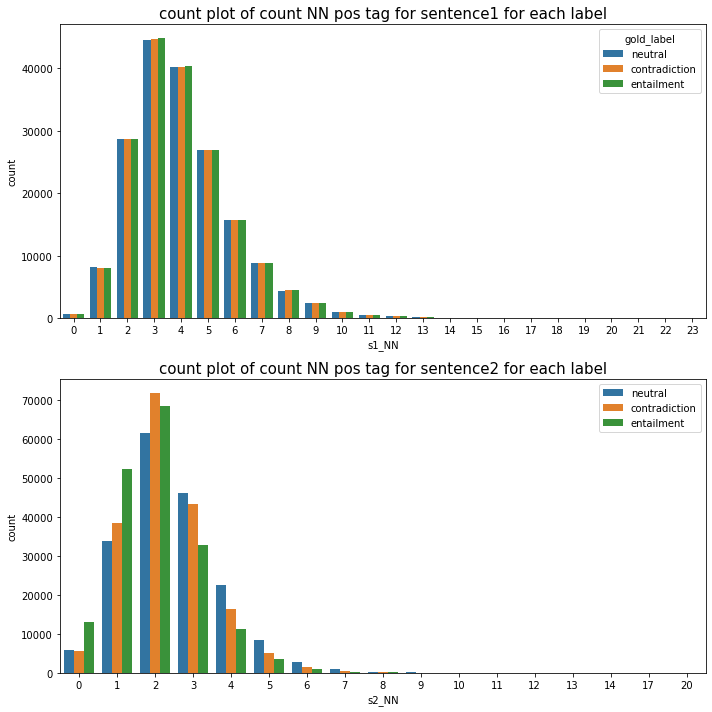

In [241]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x = train_df['s1_NN'], hue = train_df['gold_label'], ax = ax[0])
sns.countplot(x = train_df['s2_NN'], hue = train_df['gold_label'], ax = ax[1])
ax[0].set_title('count plot of count NN pos tag for sentence1 for each label', fontdict = {'fontsize': 15})
ax[0].set_ylabel('count')
ax[1].set_title('count plot of count NN pos tag for sentence2 for each label', fontdict = {'fontsize': 15})
ax[1].set_ylabel('count')
plt.tight_layout()
plt.legend(loc = "upper right")
plt.show()

NN: noun, common, singular or mass
NNP: noun, proper, singular
NNS: noun, common, plural

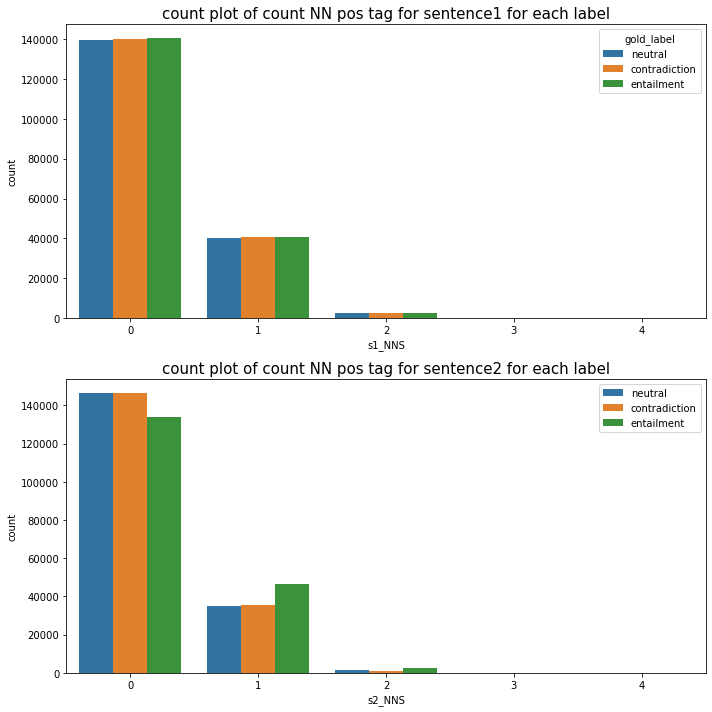

In [249]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x = train_df['s1_NNS'], hue = train_df['gold_label'], ax = ax[0])
sns.countplot(x = train_df['s2_NNS'], hue = train_df['gold_label'], ax = ax[1])
ax[0].set_title('count plot of count NN pos tag for sentence1 for each label', fontdict = {'fontsize': 15})
ax[0].set_ylabel('count')
ax[1].set_title('count plot of count NN pos tag for sentence2 for each label', fontdict = {'fontsize': 15})
ax[1].set_ylabel('count')
plt.tight_layout()
plt.legend(loc = "upper right")
plt.show()

**Let us add all noun pos tags and see the behaviour**

In [250]:
train_df['s1_noun'] = train_df['s1_NN'] + train_df['s1_NNP'] + train_df['s1_NNS']

In [251]:
train_df['s2_noun'] = train_df['s2_NN'] + train_df['s2_NNP'] + train_df['s2_NNS']

In [258]:
val_df['s1_noun'] = val_df['s1_NN'] + val_df['s1_NNP'] + val_df['s1_NNS']
val_df['s2_noun'] = val_df['s2_NN'] + val_df['s2_NNP'] + val_df['s2_NNS']
test_df['s1_noun'] = test_df['s1_NN'] + test_df['s1_NNP'] + test_df['s1_NNS']
test_df['s2_noun'] = test_df['s2_NN'] + test_df['s2_NNP'] + test_df['s2_NNS']

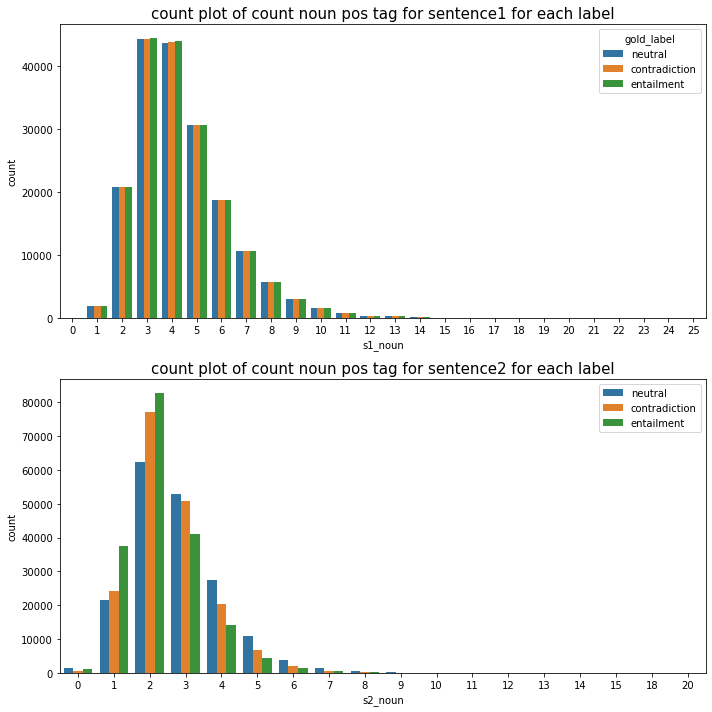

In [252]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x = train_df['s1_noun'], hue = train_df['gold_label'], ax = ax[0])
sns.countplot(x = train_df['s2_noun'], hue = train_df['gold_label'], ax = ax[1])
ax[0].set_title('count plot of count noun pos tag for sentence1 for each label', fontdict = {'fontsize': 15})
ax[0].set_ylabel('count')
ax[1].set_title('count plot of count noun pos tag for sentence2 for each label', fontdict = {'fontsize': 15})
ax[1].set_ylabel('count')
plt.tight_layout()
plt.legend(loc = "upper right")
plt.show()

In [291]:
train_df['ratio_noun'] = (train_df['s1_noun']/(train_df['s2_noun']+2))

In [296]:
val_df['ratio_noun'] = (val_df['s1_noun']/(val_df['s2_noun']+2))
test_df['ratio_noun'] = (test_df['s1_noun']/(test_df['s2_noun']+2))

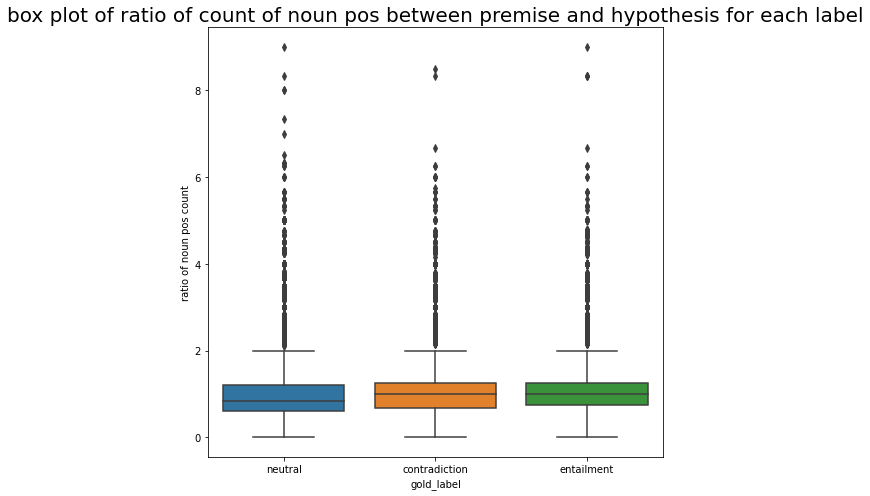

In [292]:
fig,ax = plt.subplots(1,1, figsize=(7,7), sharex=True)
sns.boxplot(x = train_df['gold_label'], y = train_df['ratio_noun'], ax = ax)
ax.set_title('box plot of ratio of count of noun pos between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('ratio of noun pos count')
plt.tight_layout()
plt.show()

In [264]:
val_df['diff_noun'] = (val_df['s1_noun'] - val_df['s2_noun']).abs()
test_df['diff_noun'] = (test_df['s1_noun'] - test_df['s2_noun']).abs()

### VB: Verb

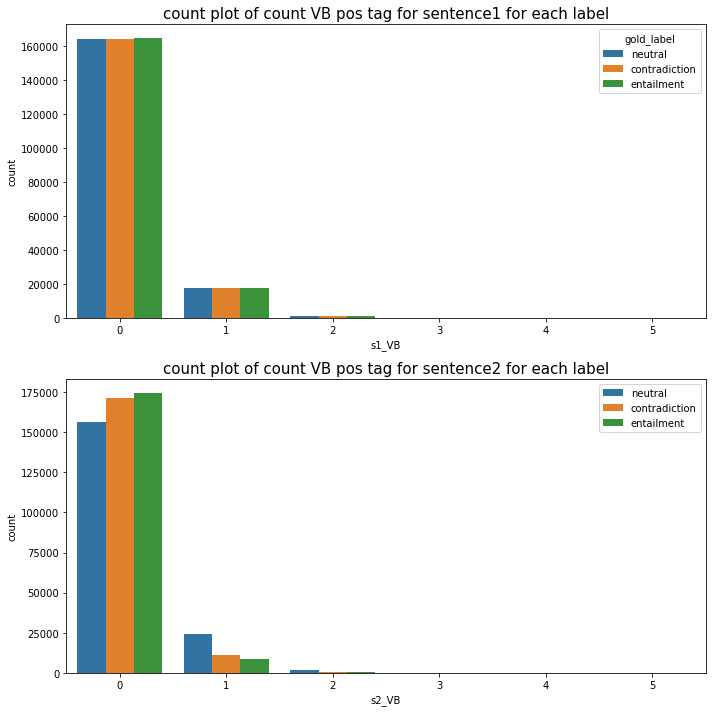

In [242]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x = train_df['s1_VB'], hue = train_df['gold_label'], ax = ax[0])
sns.countplot(x = train_df['s2_VB'], hue = train_df['gold_label'], ax = ax[1])
ax[0].set_title('count plot of count VB pos tag for sentence1 for each label', fontdict = {'fontsize': 15})
ax[0].set_ylabel('count')
ax[1].set_title('count plot of count VB pos tag for sentence2 for each label', fontdict = {'fontsize': 15})
ax[1].set_ylabel('count')
plt.tight_layout()
plt.legend(loc = "upper right")
plt.show()

VB: verb, base form
VBD: verb, past tense
VBG: verb, present participle or gerund
VBN: verb, past participle
VBP: verb, present tense, not 3rd person singular
VBZ: verb, present tense, 3rd person singular

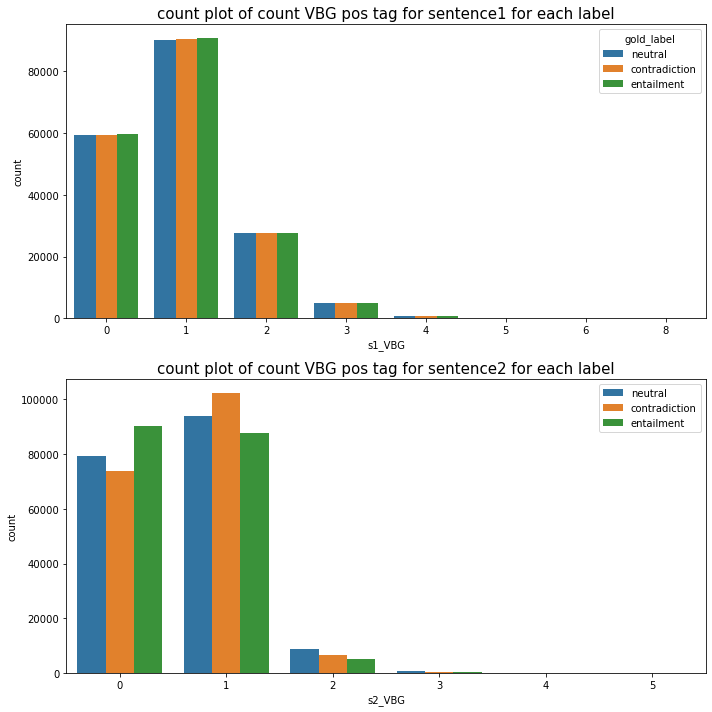

In [245]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x = train_df['s1_VBG'], hue = train_df['gold_label'], ax = ax[0])
sns.countplot(x = train_df['s2_VBG'], hue = train_df['gold_label'], ax = ax[1])
ax[0].set_title('count plot of count VBG pos tag for sentence1 for each label', fontdict = {'fontsize': 15})
ax[0].set_ylabel('count')
ax[1].set_title('count plot of count VBG pos tag for sentence2 for each label', fontdict = {'fontsize': 15})
ax[1].set_ylabel('count')
plt.tight_layout()
plt.legend(loc = "upper right")
plt.show()

In [255]:
train_df['s1_verb'] = train_df['s1_VB'] + train_df['s1_VBD'] + train_df['s1_VBG'] + train_df['s1_VBN']
train_df['s2_verb'] = train_df['s2_VB'] + train_df['s2_VBD'] + train_df['s2_VBG'] + train_df['s2_VBN']


In [259]:
val_df['s1_verb'] = val_df['s1_VB'] + val_df['s1_VBD'] + val_df['s1_VBG'] + val_df['s1_VBN']
val_df['s2_verb'] = val_df['s2_VB'] + val_df['s2_VBD'] + val_df['s2_VBG'] + val_df['s2_VBN']
test_df['s1_verb'] = test_df['s1_VB'] + test_df['s1_VBD'] + test_df['s1_VBG'] + test_df['s1_VBN']
test_df['s2_verb'] = test_df['s2_VB'] + test_df['s2_VBD'] + test_df['s2_VBG'] + test_df['s2_VBN']


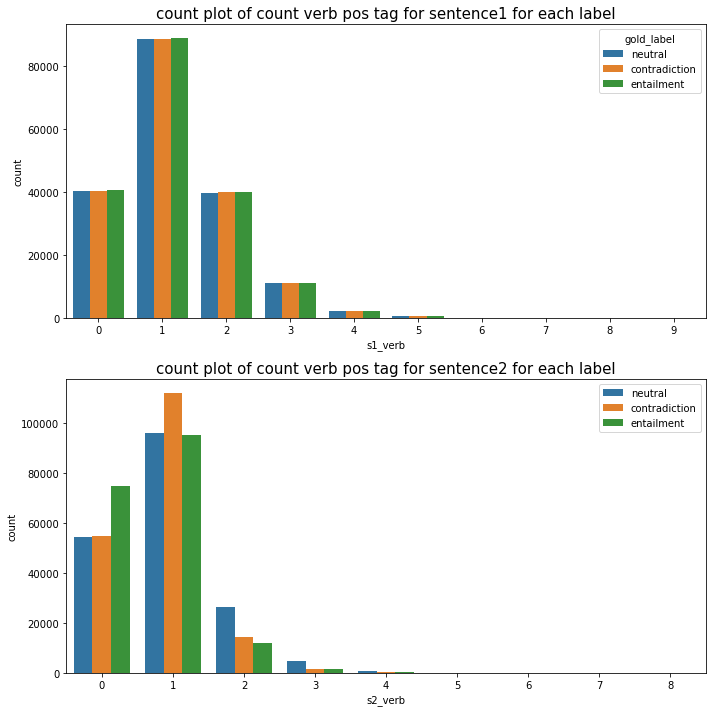

In [256]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
sns.countplot(x = train_df['s1_verb'], hue = train_df['gold_label'], ax = ax[0])
sns.countplot(x = train_df['s2_verb'], hue = train_df['gold_label'], ax = ax[1])
ax[0].set_title('count plot of count verb pos tag for sentence1 for each label', fontdict = {'fontsize': 15})
ax[0].set_ylabel('count')
ax[1].set_title('count plot of count verb pos tag for sentence2 for each label', fontdict = {'fontsize': 15})
ax[1].set_ylabel('count')
plt.tight_layout()
plt.legend(loc = "upper right")
plt.show()

#### We can keep only summed up noun and verb pos tag counts and remove rest

In [266]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')



In [267]:
train_df = pd.read_csv('train_df.csv', index_col = 0)
val_df = pd.read_csv('val_df.csv', index_col = 0)
test_df = pd.read_csv('test_df.csv', index_col = 0)

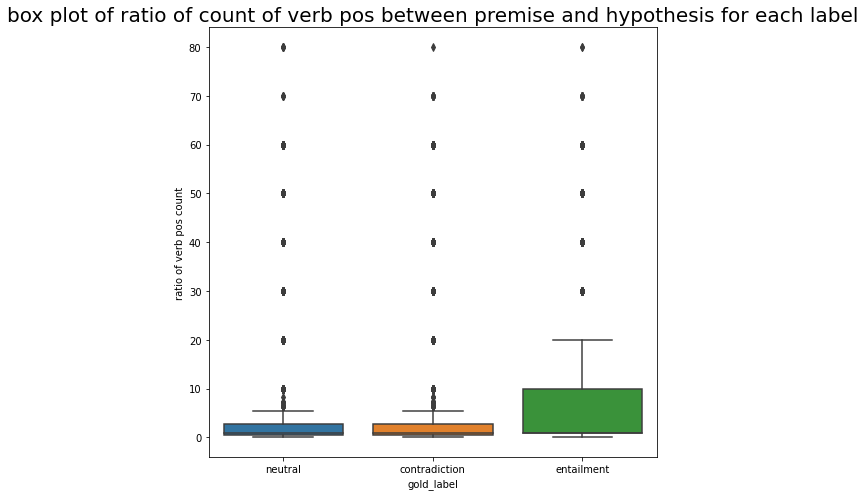

In [290]:
train_df['ratio_verb'] = (train_df['s1_verb']/(train_df['s2_verb']+1e-1))

fig,ax = plt.subplots(1,1, figsize=(7,7), sharex=True)
sns.boxplot(x = train_df['gold_label'], y = train_df['ratio_verb'], ax = ax)
ax.set_title('box plot of ratio of count of verb pos between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('ratio of verb pos count')
plt.tight_layout()
plt.show()

In [297]:
val_df['ratio_verb'] = (val_df['s1_verb']/(val_df['s2_verb']+1e-1))

In [298]:
test_df['ratio_verb'] = (test_df['s1_verb']/(test_df['s2_verb']+1e-1))

**Ratios of noun and verb pos count seem to be adding some discriminative power**

In [305]:
train_df.columns

Index(['sentence1', 'sentence2', 'gold_label', 'sentence1_preprocessed',
       'sentence2_preprocessed', 'sentence1_num_words', 'sentence2_num_words',
       'bleu_score', 'log_bleu_score', 'sentence1_polarity',
       'sentence2_polarity', 'sentence1_subjectivity',
       'sentence2_subjectivity', 'sum_polarity', 'diff_subjectivity',
       'cosine_similarity', 'tfidf_cosine_sim', 'diff_num_words', 's1_CC',
       's1_IN', 's1_JJ', 's1_JJR', 's1_JJS', 's1_NN', 's1_NNP', 's1_NNS',
       's1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS', 's1_UH', 's1_VB',
       's1_VBD', 's1_VBG', 's1_VBN', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
       's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP',
       's2_PRP$', 's2_RB', 's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD',
       's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ', 's1_noun', 's2_noun', 's1_verb',
       's2_verb', 'ratio_noun', 'ratio_verb'],
      dtype='object')

## JJ: Adjective 

In [306]:
# Let us add all adjective pos tags
train_df['s1_adjective'] = train_df['s1_JJ'] + train_df['s1_JJR'] + train_df['s1_JJS']
train_df['s2_adjective'] = train_df['s2_JJ'] + train_df['s2_JJR'] + train_df['s2_JJS']

In [320]:
val_df['s1_adjective'] = val_df['s1_JJ'] + val_df['s1_JJR'] + val_df['s1_JJS']
val_df['s2_adjective'] = val_df['s2_JJ'] + val_df['s2_JJR'] + val_df['s2_JJS']
test_df['s1_adjective'] = test_df['s1_JJ'] + test_df['s1_JJR'] + test_df['s1_JJS']
test_df['s2_adjective'] = test_df['s2_JJ'] + test_df['s2_JJR'] + test_df['s2_JJS']

In [317]:
train_df['diff_adjective'] = (train_df['s1_adjective']-train_df['s2_adjective']).abs()

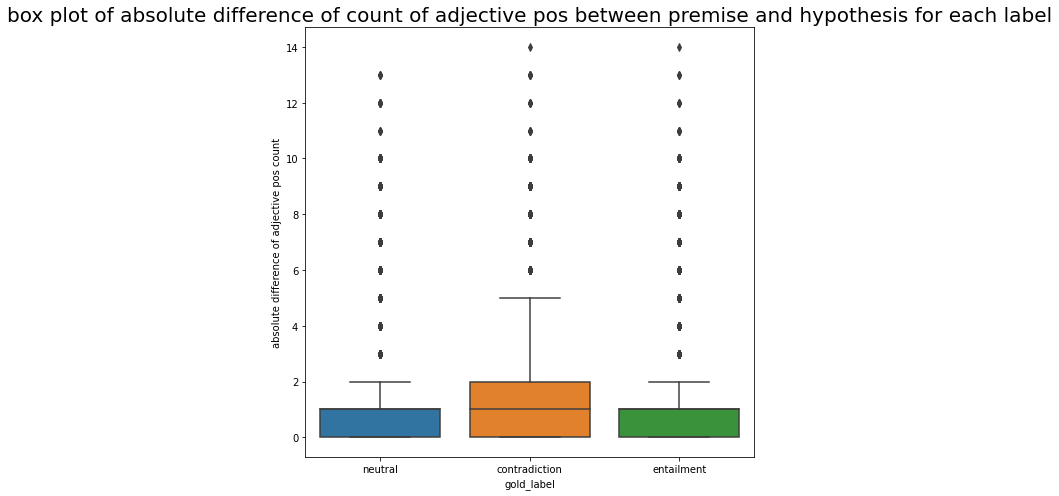

In [318]:
fig,ax = plt.subplots(1,1, figsize=(7,7), sharex=True)
sns.boxplot(x = train_df['gold_label'], y = train_df['diff_adjective'], ax = ax)
ax.set_title('box plot of absolute difference of count of adjective pos between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('absolute difference of adjective pos count')
plt.tight_layout()
plt.show()

In [321]:
val_df['diff_adjective'] = (val_df['s1_adjective']-val_df['s2_adjective']).abs()
test_df['diff_adjective'] = (test_df['s1_adjective']-test_df['s2_adjective']).abs()

In [324]:
train_df.columns

Index(['sentence1', 'sentence2', 'gold_label', 'sentence1_preprocessed',
       'sentence2_preprocessed', 'sentence1_num_words', 'sentence2_num_words',
       'bleu_score', 'log_bleu_score', 'sentence1_polarity',
       'sentence2_polarity', 'sentence1_subjectivity',
       'sentence2_subjectivity', 'sum_polarity', 'diff_subjectivity',
       'cosine_similarity', 'tfidf_cosine_sim', 'diff_num_words', 's1_CC',
       's1_IN', 's1_JJ', 's1_JJR', 's1_JJS', 's1_NN', 's1_NNP', 's1_NNS',
       's1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS', 's1_UH', 's1_VB',
       's1_VBD', 's1_VBG', 's1_VBN', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
       's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP',
       's2_PRP$', 's2_RB', 's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD',
       's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ', 's1_noun', 's2_noun', 's1_verb',
       's2_verb', 'ratio_noun', 'ratio_verb', 's1_adjective', 's2_adjective',
       'diff_adjective'],
      dtype='object')

## Levenshtein Distance

how many transformations you need to perform on the string A to make it equal to string B

In [329]:
def get_levenshtein(s1, s2):
    d = Levenshtein.distance(s1,s2)
    return d
    

In [332]:
levelshtein_dist = list()
for i,row in train_df.iterrows():
    d = get_levenshtein(row['sentence1'], row['sentence2'])
    levelshtein_dist.append(d)

In [333]:
train_df['levenshtein_dist'] = levelshtein_dist

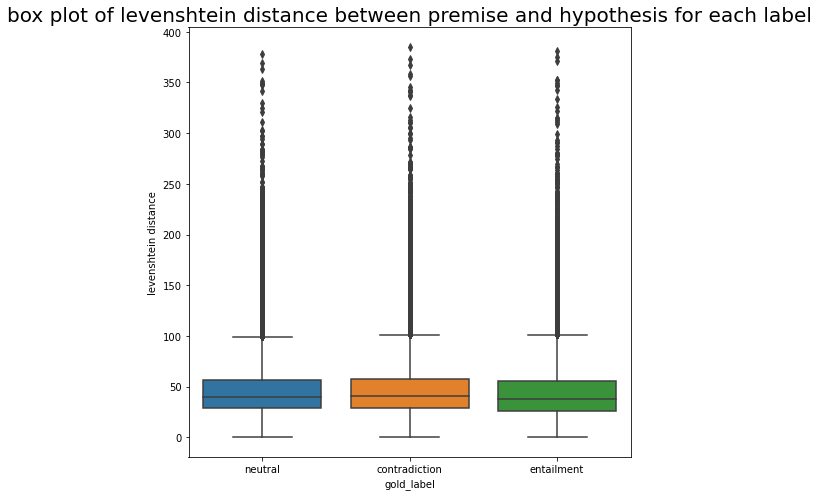

In [335]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
sns.boxplot(x = train_df['gold_label'], y = train_df['levenshtein_dist'], ax = ax)
ax.set_title('box plot of levenshtein distance between premise and hypothesis for each label', fontdict = {'fontsize': 20})
ax.set_ylabel('levenshtein distance')
plt.tight_layout()
plt.show()

In [341]:
levelshtein_dist = list()
for i,row in val_df.iterrows():
    d = get_levenshtein(row['sentence1'], row['sentence2'])
    levelshtein_dist.append(d)

In [342]:
val_df['levenshtein_dist'] = levelshtein_dist

In [343]:
levelshtein_dist = list()
for i,row in test_df.iterrows():
    d = get_levenshtein(row['sentence1'], row['sentence2'])
    levelshtein_dist.append(d)

In [344]:
test_df['levenshtein_dist'] = levelshtein_dist

In [347]:
train_df.columns

Index(['sentence1', 'sentence2', 'gold_label', 'sentence1_preprocessed',
       'sentence2_preprocessed', 'sentence1_num_words', 'sentence2_num_words',
       'bleu_score', 'log_bleu_score', 'sentence1_polarity',
       'sentence2_polarity', 'sentence1_subjectivity',
       'sentence2_subjectivity', 'sum_polarity', 'diff_subjectivity',
       'cosine_similarity', 'tfidf_cosine_sim', 'diff_num_words', 's1_CC',
       's1_IN', 's1_JJ', 's1_JJR', 's1_JJS', 's1_NN', 's1_NNP', 's1_NNS',
       's1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS', 's1_UH', 's1_VB',
       's1_VBD', 's1_VBG', 's1_VBN', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
       's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP',
       's2_PRP$', 's2_RB', 's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD',
       's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ', 's1_noun', 's2_noun', 's1_verb',
       's2_verb', 'ratio_noun', 'ratio_verb', 's1_adjective', 's2_adjective',
       'diff_adjective', 'levenshtein_dist'],
      dty

In [361]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')

In [362]:
train_df = pd.read_csv('train_df.csv', index_col = 0)
val_df = pd.read_csv('val_df.csv', index_col = 0)
test_df = pd.read_csv('test_df.csv', index_col = 0)

In [349]:
to_keep_x = ['sentence1_num_words', 'sentence2_num_words', 'log_bleu_score', 'sum_polarity', 'diff_subjectivity',
       'cosine_similarity', 'tfidf_cosine_sim', 'diff_num_words', 's1_CC',
       's1_IN', 's1_JJ', 's1_JJR', 's1_JJS','s1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS', 's1_UH', 's1_VBP', 's1_VBZ', 's2_CC', 's2_IN',
       's2_JJ', 's2_JJR', 's2_JJS', 's2_NN', 's2_NNP', 's2_NNS', 's2_PRP',
       's2_PRP$', 's2_RB', 's2_RBR', 's2_RBS', 's2_UH', 's2_VB', 's2_VBD',
       's2_VBG', 's2_VBN', 's2_VBP', 's2_VBZ', 'ratio_noun', 'ratio_verb', 'levenshtein_dist']

In [350]:
X_train = train_df[to_keep_x]
y_train = train_df['gold_label']
X_val = val_df[to_keep_x]
y_val = val_df['gold_label']

In [353]:
# hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100,200,500,600,800]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [5,10,20,40,80]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, random_state=42, n_jobs = 6)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=6,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 10, 20, 40, 80],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 4, 10],
                                        'min_samples_split': [5, 10, 20, 40],
                                        'n_estimators': [100, 200, 500, 600,
                                                         800]},
                   random_state=42)

In [354]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=800)

In [355]:
rf_random.best_score_

0.559056795693159

In [356]:
model = RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=800)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=800)

In [357]:
val_pred = model.predict(X_val)

In [359]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_val, val_pred)

In [360]:
acc

0.5722414143466775

In [364]:
importance = model.feature_importances_

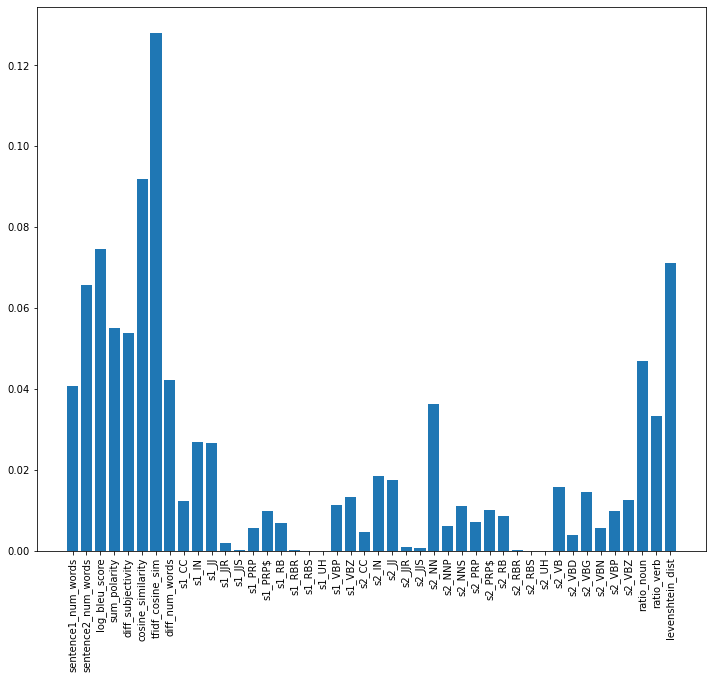

In [365]:
# Plotting feature importance
columns = X_train.columns
x_pos = np.arange(len(columns))
plt.figure(figsize = (12,10))
plt.bar(x_pos, importance)
plt.xticks(x_pos, columns, rotation='vertical')
plt.show()
#plt.plot(np.array(range(0,47)), importance, 'bo' )